Uncomment this section if imports below fail

In [43]:

# %pip install tensorflow
# %pip install keras
# %pip install matplotlib
# %pip install opencv-python opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Get data from kaggle 
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
! unzip lung-and-colon-cancer-histopathological-images.zip

In [44]:

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
from cv2 import imread
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

# Data preparation
From the data set we have 5000 images from each class and to make sure that we are taking the right amount for our training and testing data we need to section this 5000x5 into evenly split training and testing data. To do this we are going to take 80% of the data for training and using the last 20% of the data for testing. This comes out to 5000*.8= 4000 images per classification for training and 5000*.2 images per classification for testing. This comes out to a total of 20,000 images to train on and 5000 images to test on. The following code will represent how that will be taken place

## Load in Data

(768, 768, 3)

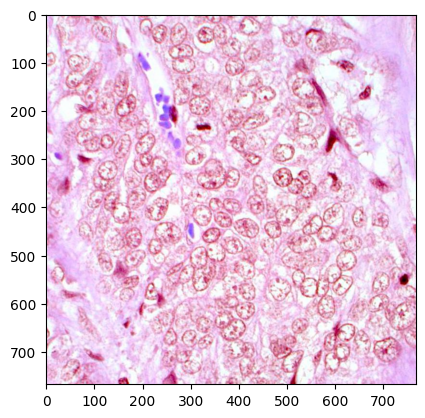

In [45]:
# Find out the dims of our images
img = imread(os.path.join('lung_colon_image_set','colon_aca','colonca1.jpeg'))
plt.imshow(img)
img.shape

In [1]:
# Get classifications from the strucutre of the directory
# Classifications = os.listdir('lung_colon_image_set')
classifications = ['colon_aca','colon_n','lung_aca','lung_n','lung_scc']

# Load the data
data = tf.keras.utils.image_dataset_from_directory('lung_colon_image_set',class_names=classifications,shuffle=True)

NameError: name 'tf' is not defined

# Lets look at the data and see what it looks like 

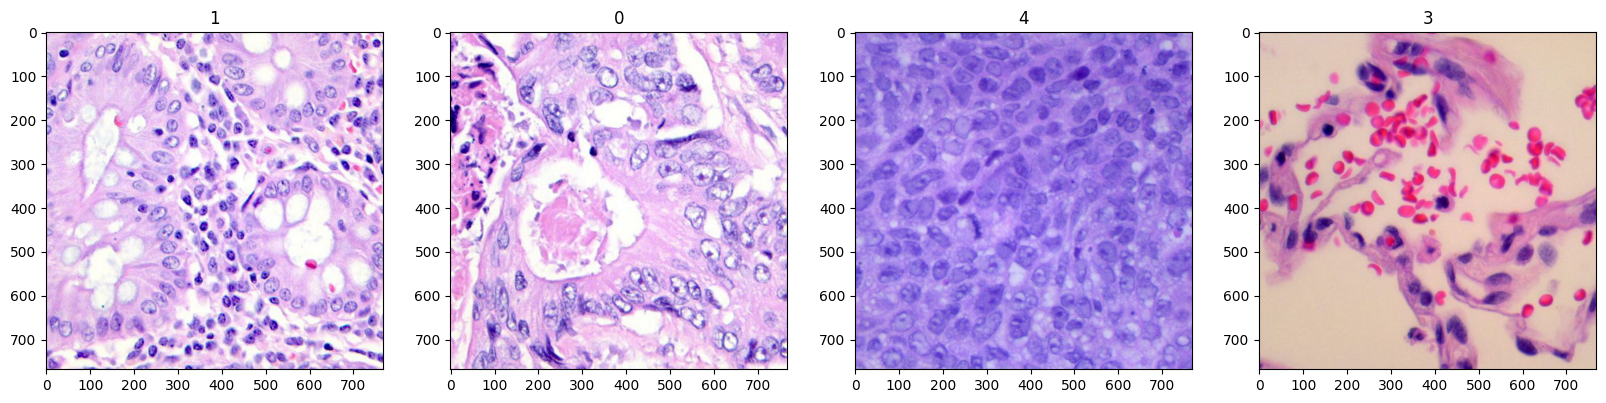

In [47]:
data_iterator = data.as_numpy_iterator()

batch = next(data_iterator)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale the data for easier classification

In [48]:
data = data.map(lambda x,y: (x/255, y))

data.as_numpy_iterator().next()

(array([[[[0.8901961 , 0.7490196 , 0.8901961 ],
          [0.89411765, 0.7529412 , 0.89411765],
          [0.8862745 , 0.74509805, 0.8862745 ],
          ...,
          [0.8784314 , 0.7372549 , 0.8392157 ],
          [0.8784314 , 0.7490196 , 0.8156863 ],
          [0.9019608 , 0.7764706 , 0.827451  ]],
 
         [[0.9019608 , 0.7607843 , 0.9098039 ],
          [0.9098039 , 0.76862746, 0.9098039 ],
          [0.9098039 , 0.76862746, 0.91764706],
          ...,
          [0.8784314 , 0.74509805, 0.8509804 ],
          [0.88235295, 0.7529412 , 0.827451  ],
          [0.90588236, 0.78431374, 0.84313726]],
 
         [[0.9019608 , 0.75686276, 0.91764706],
          [0.9137255 , 0.77254903, 0.92156863],
          [0.9254902 , 0.78039217, 0.9411765 ],
          ...,
          [0.8745098 , 0.75686276, 0.8666667 ],
          [0.8862745 , 0.77254903, 0.85882354],
          [0.9098039 , 0.79607844, 0.8666667 ]],
 
         ...,
 
         [[0.49803922, 0.35686275, 0.78039217],
          [0.6    

## Split the data

In [49]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [50]:
train_size

547

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [1]:
layers = [Conv2D(32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(),
        Dense(5, activation='softmax')]
model = Sequential(layers)
# model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=img.shape))
# model.add(MaxPooling2D())
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

NameError: name 'Conv2D' is not defined

In [53]:
learning_rate = .001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 766, 766, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 383, 383, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 381, 381, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 190, 190, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 188, 188, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 94, 94, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 141376)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    36,192,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,202,481 (138.10 MB)

 Trainable params: 36,202,481 (138.10 MB)

 Non-trainable params: 0 (0.00 B)

# Training
The fun part about seeing if the model works well :smiley:

In [55]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
524/547 ━━━━━━━━━━━━━━━━━━━━ 1:56 5s/step - accuracy: 0.2023 - loss: -381450813440.0000

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

In [ ]:
img = imread(os.path.join('lung_colon_image_set','colon_aca','colonca1.jpeg'))
plt.imshow(img)
plt.show()

In [ ]:
yhat = model.predict(img)

yhat